In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)


def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

/home/llr/cms/motta/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/llr/cms/motta/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [2]:
options = {
    'v'          : '16',
    'date'       : '2023_05_28',
    'inTagIdent' : '_QP',
    'inTagCalib' : '_QP',
    'caloClNxM'  : '5x9',
    'sparsity'   : 0.5
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/TauMinator_CB_cltw'+options['caloClNxM']+'_Training'+options['inTagIdent']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

sparsityTag = str(options['sparsity']).split('.')[0]+'p'+str(options['sparsity']).split('.')[1]

In [4]:
X1 = np.load(indir+'/tensors/images_valid.npz')['arr_0']
X2 = np.load(indir+'/tensors/posits_valid.npz')['arr_0']
Y  = np.load(indir+'/tensors/target_valid.npz')['arr_0']
Yid  = Y[:,1].reshape(-1,1)
Ycal = Y[:,0].reshape(-1,1)

X1_id_reduced = X1[:3000]
X2_id_reduced = X2[:3000]
Y_id_reduced = Yid[:3000]


# select only taus
tau_sel = Yid.reshape(1,-1)[0] > 0
X1_cal = X1[tau_sel]
X2_cal = X2[tau_sel]
Y_cal = Y[tau_sel]
Ycal = Ycal[tau_sel]

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
Y_cal_reduced = Ycal[:3000]

In [5]:
# quantized and pruned models
QCNN = keras.models.load_model(indir+'/CNNmodel', compile=False)
QDNNident = keras.models.load_model(indir+'/ID_DNNmodel', compile=False)
QDNNcalib = keras.models.load_model(indir+'/CAL_DNNmodel', compile=False)

2023-06-01 08:56:24.155787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2023-06-01 08:56:24.155818: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-01 08:56:24.156249: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

In [6]:
# original floating point model without pruning
CNN_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CB_cltw5x9_Training/CNNmodel', compile=False)
DNNident_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CB_cltw5x9_Training/ID_DNNmodel', compile=False)
DNNcalib_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CB_cltw5x9_Training/CAL_DNNmodel', compile=False)

# QUANTIZED MODELS ONLY

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_ufixed<10,8>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNpBNlayer1': {'Precision': {'weight': 'ap_fixed<5,1>', 'bias': 'ap_fixed<6,1>', 'accum': 'ap_fix

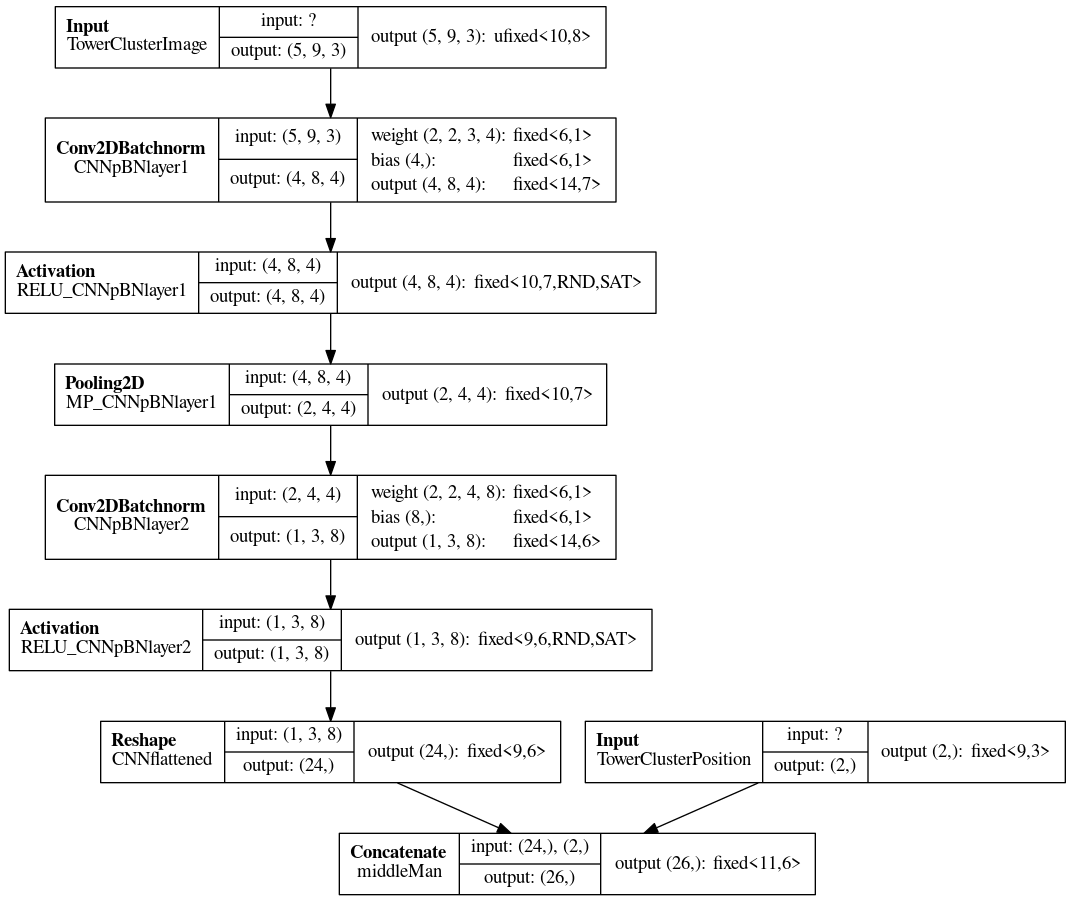

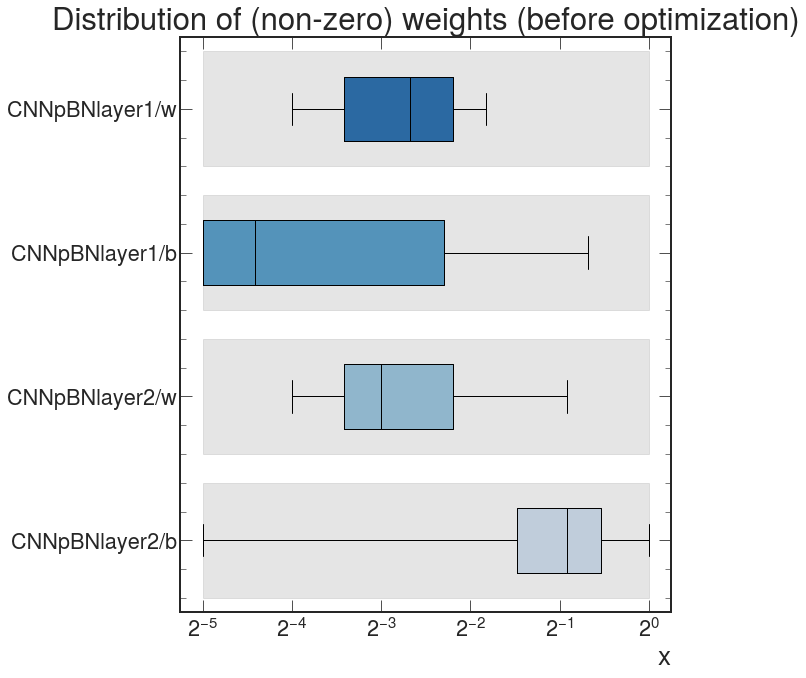

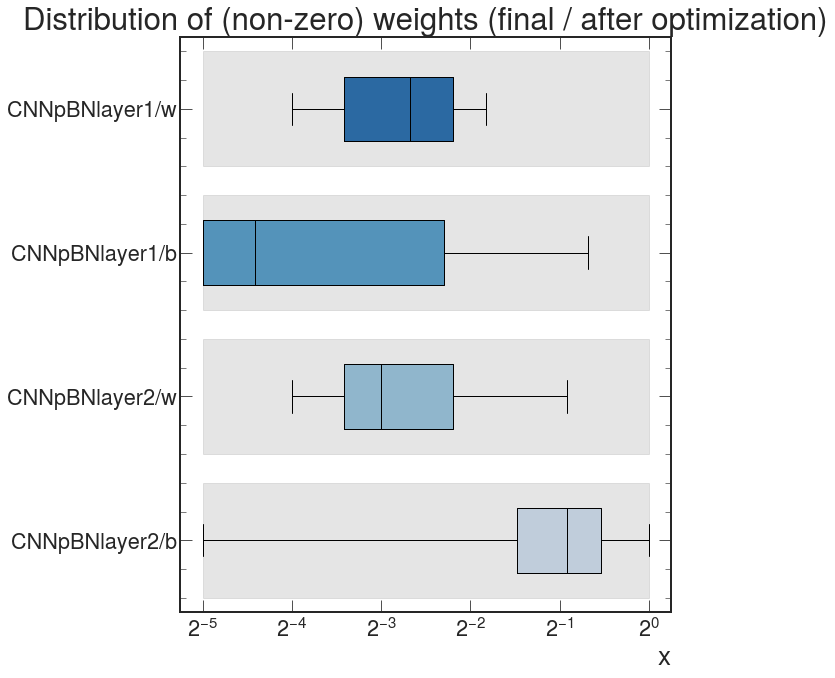

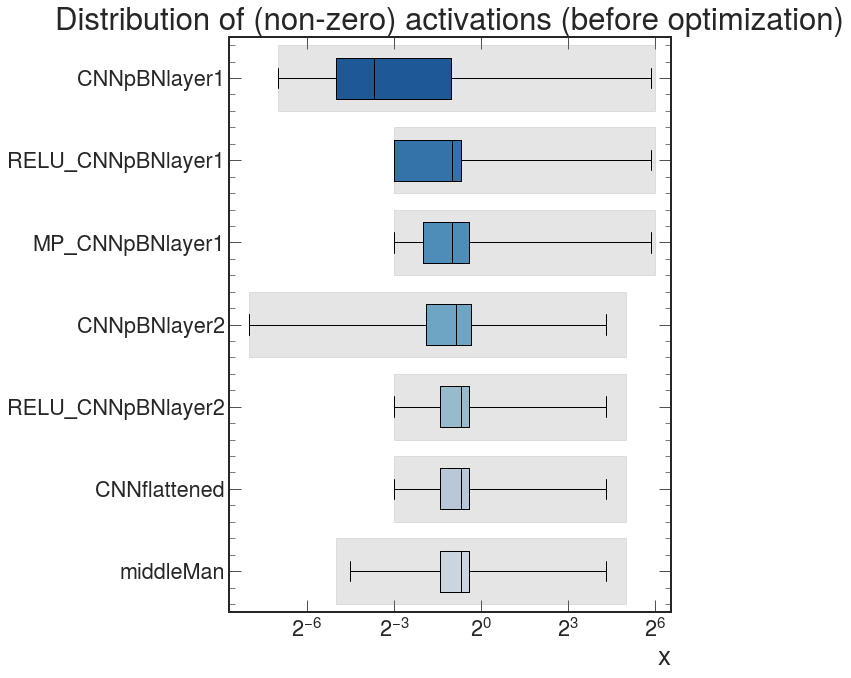

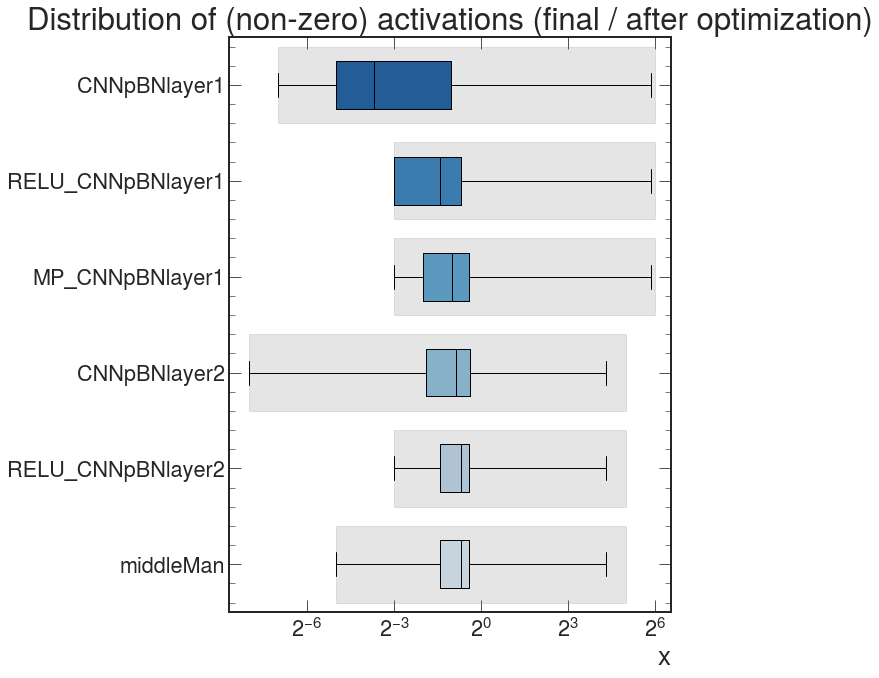

In [7]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_ufixed<10,8>'
QCNN_hls_cfg['LayerName']['TowerClusterPosition']['Precision'] = 'ap_fixed<9,3>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['ParallelizationFactor'] = 4
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['weight'] = 'ap_fixed<5,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['bias'] = 'ap_fixed<6,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<14,7>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<14,7>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<10,7>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['MP_CNNpBNlayer1']['Precision'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['weight'] = 'ap_fixed<5,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['bias'] = 'ap_fixed<6,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<14,6>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<14,6>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<9,6>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<9,6>'

QCNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']  = QCNN_hls_cfg
QCNN_cfg['KerasModel'] = QCNN
QCNN_cfg['OutputDir']  = indir+'/CNNmodel_HLS_vu9p/'
QCNN_cfg['Part']       = 'xcvu9p-flgb2104-1-e'
QCNN_cfg['XilinxPart'] = 'xcvu9p-flgb2104-1-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: middleMan, layer type: Input
Layer name: IDlayer1, layer type: QDense
  -> Activation (linear), layer name: IDlayer1
Layer name: RELU_IDlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_IDlayer1
Layer name: IDlayer2, layer type: QDense
  -> Activation (linear), layer name: IDlayer2
Layer name: RELU_IDlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_IDlayer2
Layer name: IDout, layer type: QDense
  -> Activation (linear), layer name: IDout
Layer name: sigmoid_IDout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'middleMan': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'IDlayer1': {'Precision': {'weight': 'ap_fixed<3,1>', 'accum': 'ap_fixed<13,6>', 'result': 'ap_fixed<9,7>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'IDlayer1_linear': {

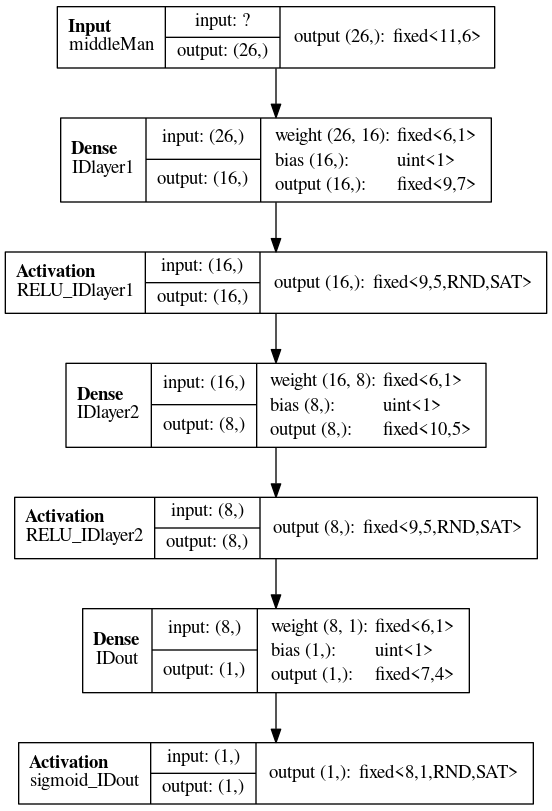

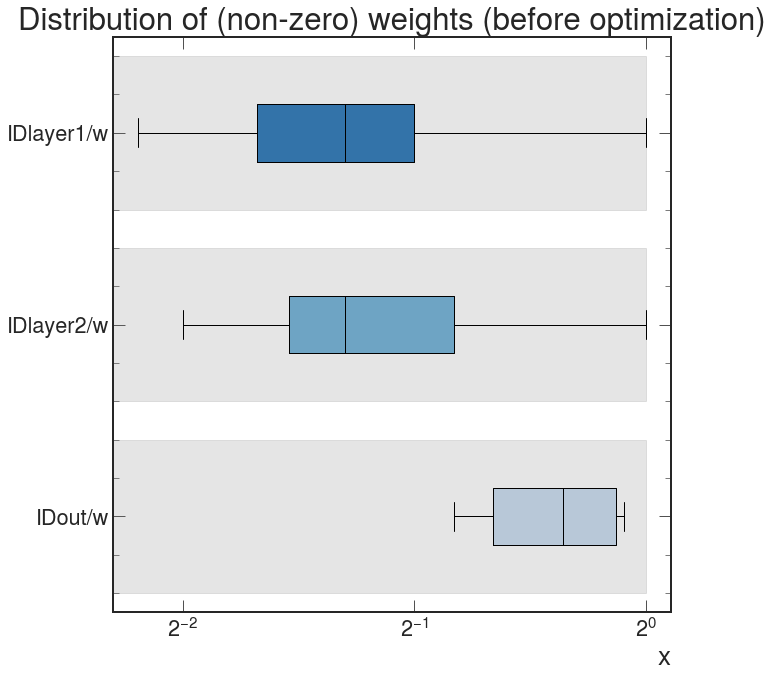

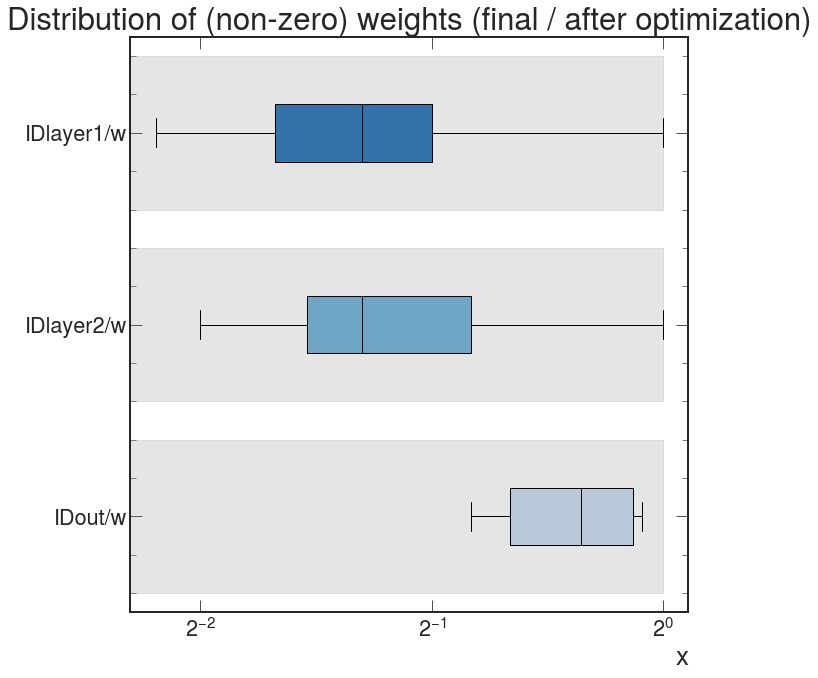

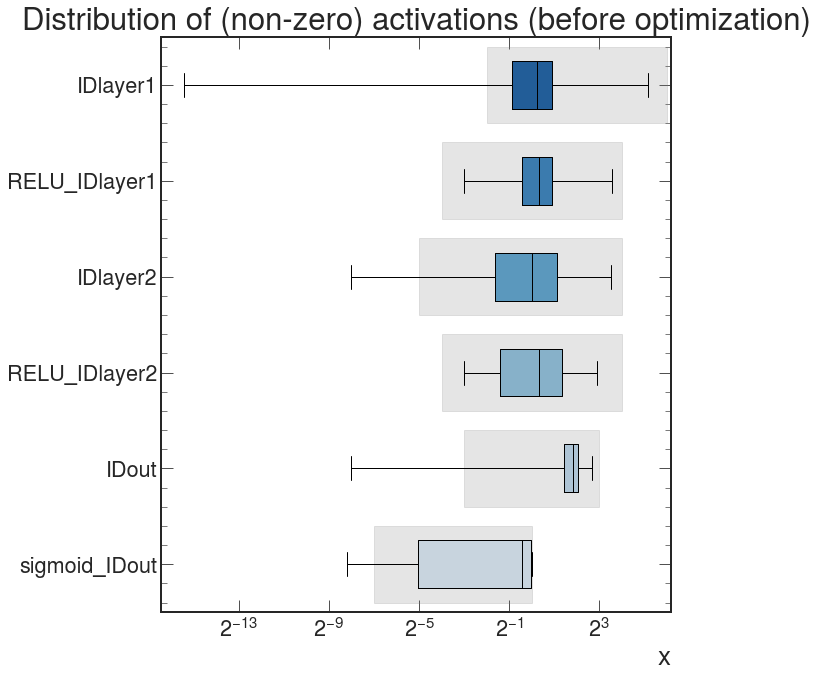

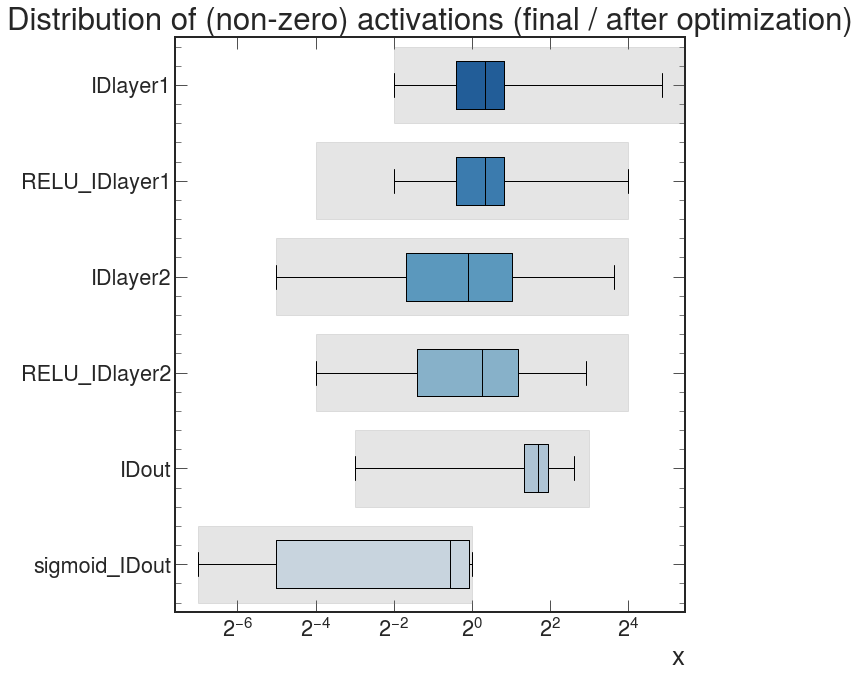

In [8]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    
id_QDNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'

id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['weight'] = 'ap_fixed<3,1>'
id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['accum'] = 'ap_fixed<13,6>'
id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['result'] = 'ap_fixed<9,7>'
id_QDNN_hls_cfg['LayerName']['RELU_IDlayer1']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['weight'] = 'ap_fixed<3,1>'
id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['accum'] = 'ap_fixed<11,6>'
id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['result'] = 'ap_fixed<10,5>'
id_QDNN_hls_cfg['LayerName']['RELU_IDlayer2']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['weight'] = 'ap_fixed<2,1>'
id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['accum'] = 'ap_fixed<7,4>'
id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['result'] = 'ap_fixed<7,4>'

id_QDNN_hls_cfg['LayerName']['sigmoid_IDout']['Precision'] = 'ap_fixed<8,1>'
id_QDNN_hls_cfg['LayerName']['sigmoid_IDout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_stream'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = indir+'/ID_DNNmodel_HLS_vu9p/'
id_QDNN_cfg['Part']       = 'xcvu9p-flgb2104-1-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu9p-flgb2104-1-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: middleMan, layer type: Input
Layer name: CALlayer1, layer type: QDense
  -> Activation (linear), layer name: CALlayer1
Layer name: RELU_CALlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CALlayer1
Layer name: CALlayer2, layer type: QDense
  -> Activation (linear), layer name: CALlayer2
Layer name: RELU_CALlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CALlayer2
Layer name: CALout, layer type: QDense
  -> Activation (linear), layer name: CALout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'middleMan': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'CALlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'accum': 'ap_fixed<16,5>', 'result': 'ap_fixed<16,7>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'CALlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'Reuse

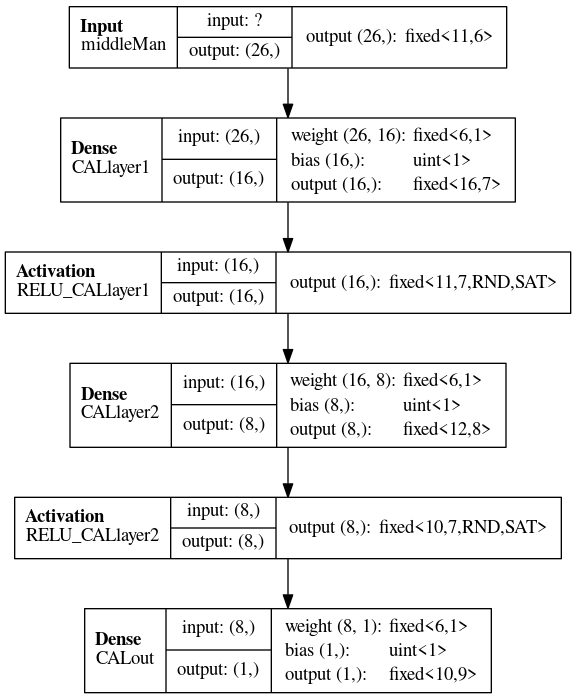

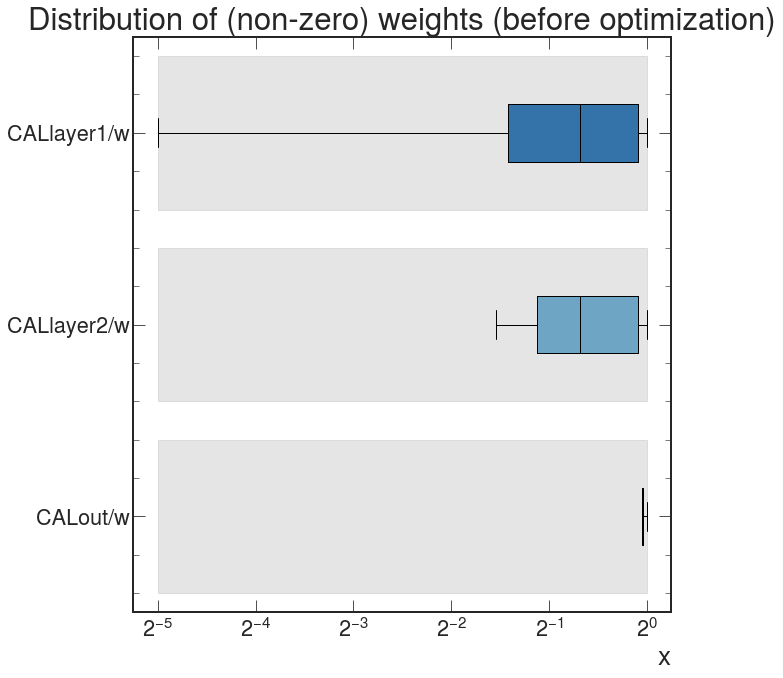

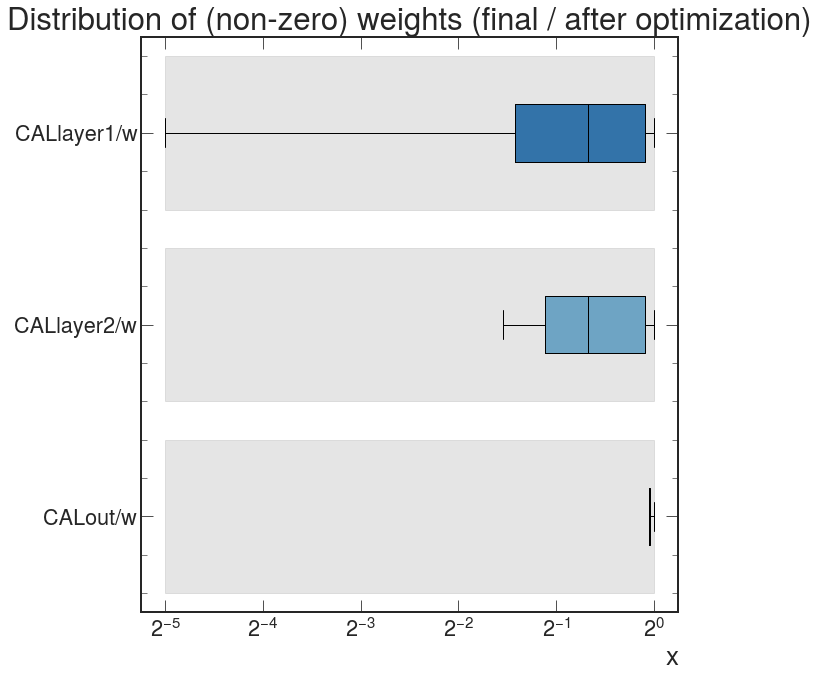

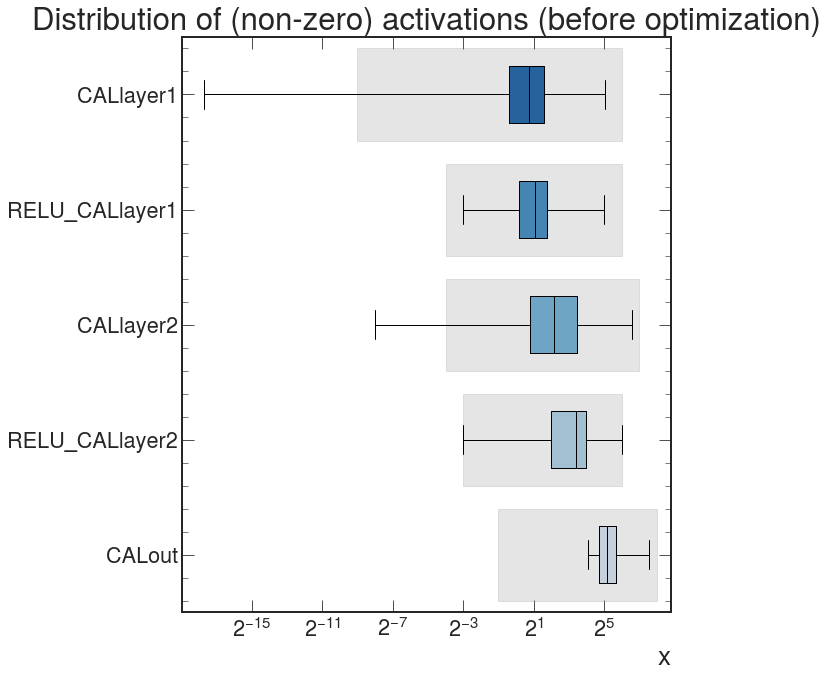

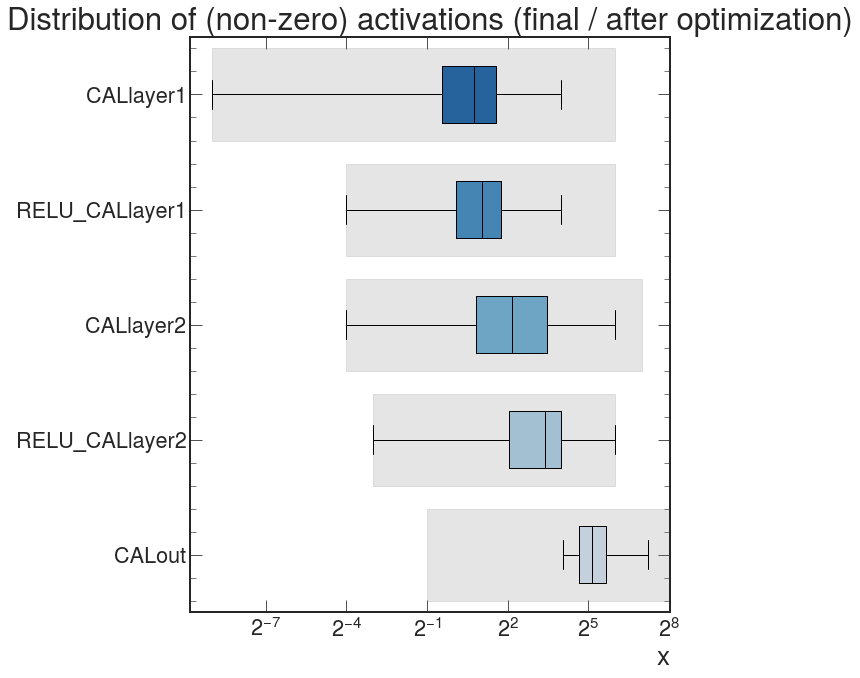

In [9]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'

cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['accum'] = 'ap_fixed<16,5>'
cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['result'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['RELU_CALlayer1']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['weight'] = 'ap_fixed<3,1>'
cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['accum'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['result'] = 'ap_fixed<12,8>'
cal_QDNN_hls_cfg['LayerName']['RELU_CALlayer2']['Precision'] = 'ap_fixed<10,7>'

cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['weight'] = 'ap_fixed<2,1>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['accum'] = 'ap_fixed<12,9>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['result'] = 'ap_fixed<10,9>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = indir+'/CAL_DNNmodel_HLS_vu9p/'
cal_QDNN_cfg['Part']       = 'xcvu9p-flgb2104-1-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu9p-flgb2104-1-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [10]:
def plotROC(Y, y_pred, y_pred_hls4ml, y_pred_fullfloat, label="Model", Xrange=None, Yrange=None, Yscale=None):    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    FPR_FF, TPR_FF, THR_FF = metrics.roc_curve(Y, y_pred_fullfloat)
    AUC_FF = metrics.roc_auc_score(Y, y_pred_fullfloat)
    
    plt.plot(TPR_FF, FPR_FF, label='Keras Floating Point ROC, AUC = %.3f' % (AUC_FF), color='red',lw=2)
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS Firmware ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=24)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.grid(linestyle=':')
    if Xrange: plt.xlim(Xrange)
    if Yrange: plt.ylim(Yrange)
    if Yscale: plt.yscale(Yscale)
    mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

In [11]:
y_ident_ff = DNNident_FullFloat.predict(CNN_FullFloat.predict([X1, X2]))
y_calib_ff = DNNcalib_FullFloat.predict(CNN_FullFloat.predict([X1_cal, X2_cal]))

In [12]:
y_ident_q        = QDNNident.predict(QCNN.predict([X1, X2]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1, X2]))

In [13]:
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal]))

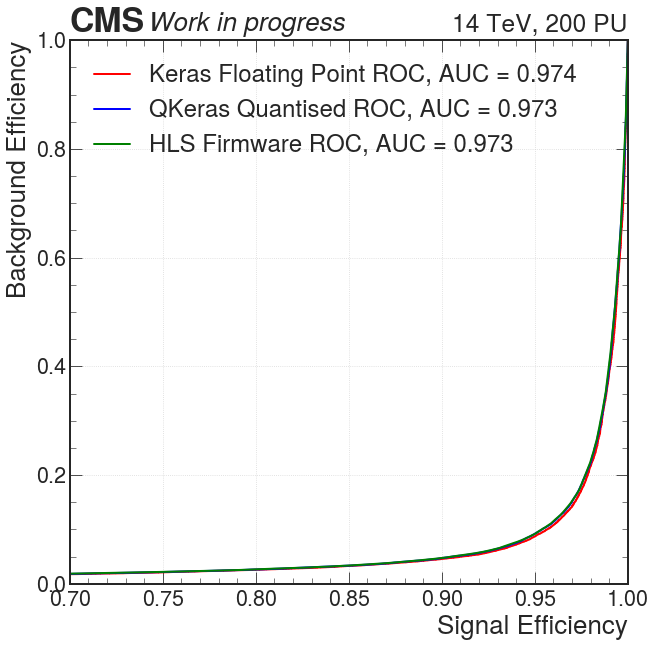

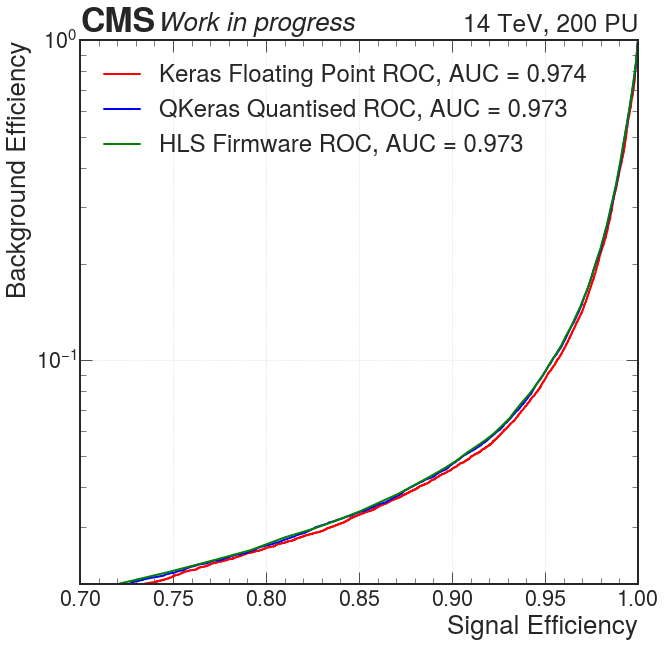

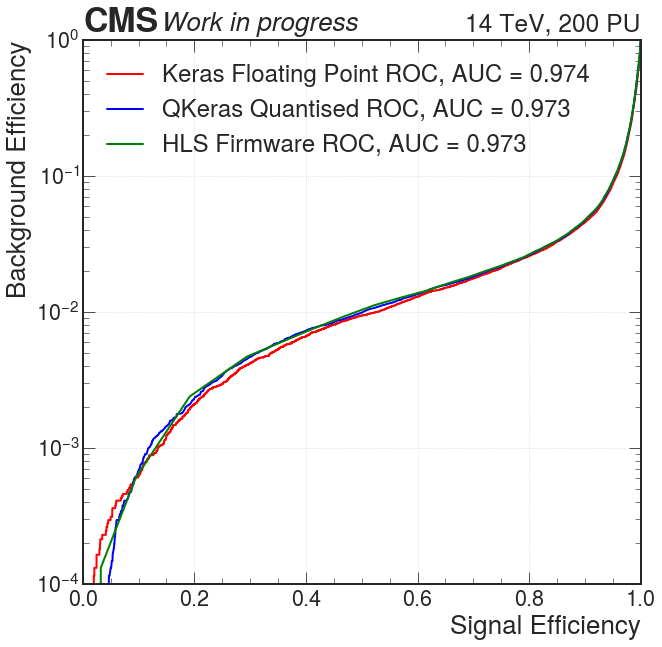

In [14]:
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Xrange=(0.7,1), Yrange=(0,1))
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.7,1), Yrange=(0.02,1))
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.,1), Yrange=(0.0001,1))

In [15]:
ravelled = Ycal[:,0]

response_q = y_calib_q.ravel() / ravelled
response_q_hls4ml = y_calib_hls4ml_q.ravel() / ravelled
response_ff = y_calib_ff.ravel() / ravelled

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in progress'))

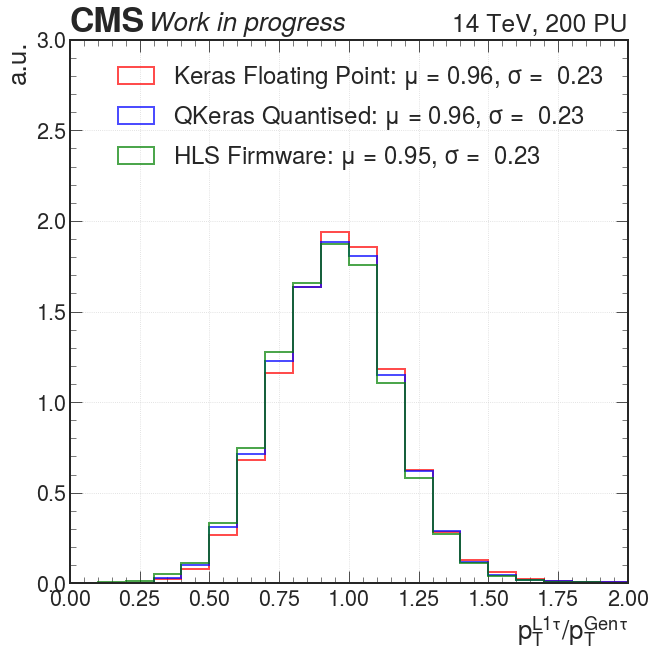

In [16]:
plt.figure(figsize=(10,10))
plt.hist(response_ff,       bins=np.arange(0,5,0.1), label=r'Keras Floating Point: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_ff), np.std(response_ff)), color='red', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Quantised: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'HLS Firmware: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.)
plt.legend(loc = 'upper right', fontsize=24)
plt.grid(linestyle='dotted')
mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

# SYNTHESISE HLS MODELS

In [20]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True, cosim=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Jun 01 09:19:10 CEST 2023
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMi

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:25 ; elapsed = 00:00:30 . Memory (MB): peak = 1125.398 ; gain = 603.309 ; free physical = 9223 ; free virtual = 122789
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config6>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'PartitionLoop' (firmware/nnet_utils/nnet_conv2d_latency.h:196) in function 'nnet::conv_2d_cl<ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' for pipelining.
INFO: [

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:00:48 ; elapsed = 00:00:54 . Memory (MB): peak = 1377.254 ; gain = 855.164 ; free physical = 9003 ; free virtual = 122568
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 54.35 seconds; current allocated memory: 465.388 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.15 seconds; current allocated memory: 530.606 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.31 seconds; current allocated memory: 531.644 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-archite

INFO: [HLS 200-790] **** Loop Constraint Status: All loop constraints were satisfied.
INFO: [HLS 200-789] **** Estimated Fmax: 228.65 MHz
INFO: [RTMG 210-285] Implementing FIFO 'TowerClusterPosition_V_c_U(fifo_w18_d6_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_0_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_1_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_2_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_3_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_4_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_5_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_6_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_7_V_U(fifo_w14_d2_A)' using Shift

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_84_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_85_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_86_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_87_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_88_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_89_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_90_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_91_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_92_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_93_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_42_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_43_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_44_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_45_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_46_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_47_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_48_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_49_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_50_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_51_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO '

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_2_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_3_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_4_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_5_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_6_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_7_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_8_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_9_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_10_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_11_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO

INFO: Unable to open input/predictions file, using default input.
0 0.625 0 0.875 1 0.5 0.75 0 0 0.625 0 0.875 1 0.5 0.75 0 0 0.625 0 0.875 1 0.5 0.75 0 0 0 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO: [COSIM 212-333] Generating C post check test bench ...
INFO: [COSIM 212-12] Generating RTL test bench ...
INFO: [COSIM 212-1] *** C/RTL co-simulation file generation completed. ***
INFO: [COSIM 212-211] II is measurable only when transaction number is greater than 1 in RTL simulation. Otherwise, they will be marked as all NA. If user wants to calculate them, please make sure there are at least 2 transactions in RTL simulation.
INFO: [COSIM 212-302] Starting C TB testing ...  
INFO: Unable to open input/predictions file, using default input.
0 0.625 0 0.875 1 0.5 0.75 0 0 0.625 0 0.875 1 0.5 0.75 0 0 0.625 0 0.875 1 0.5 0.75 0 0 0 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO: [COSIM 212-323] Starting verilog simulation...
INFO: 

Starting static elaboration
Pass Through NonSizing Optimizer
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling module xil_defaultlib.fill_buffer
Compiling module xil_defaultlib.myproject_mux_1287_1_1_1(ID=1,di...
Compiling module xil_defaultlib.myproject_mux_1287_14_1_1(ID=1,d...
Compiling module xil_defaultlib.conv_2d_cl_ap_ufixed_ap_fixed_14...
Compiling module xil_defaultlib.relu_ap_fixed_ap_fixed_10_7_0_0_...
Compiling module xil_defaultlib.myproject_mux_42_10_1_1(ID=1,din...
Compiling module xil_defaultlib.pool_op_ap_fixed_10_7_0_0_0_4_0_...
Compiling module xil_defaultlib.pooling2d_cl_ap_fixed_ap_fixed_1...
Compiling module xil_defaultlib.myproject_mux_325_1_1_1(ID=1,din...
Compiling module xil_defaultlib.myproject_mux_325_14_1_1(ID=1,di...
Compiling module xil_defaultlib.conv_2d_cl_ap_fixed_ap_fixed_14_...
Compiling module xil_defaultlib.relu_ap_fixed_ap_fixed_9_6_0_0_0...
C

////////////////////////////////////////////////////////////////////////////////////
// Inter-Transaction Progress: Completed Transaction / Total Transaction
// Intra-Transaction Progress: Measured Latency / Latency Estimation * 100%
//
// RTL Simulation : "Inter-Transaction Progress" ["Intra-Transaction Progress"] @ "Simulation Time"
////////////////////////////////////////////////////////////////////////////////////
// RTL Simulation : 0 / 1 [0.00%] @ "113000"
// RTL Simulation : 1 / 1 [100.00%] @ "223000"
////////////////////////////////////////////////////////////////////////////////////
$finish called at time : 242500 ps : File "/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/sim/verilog/myproject.autotb.v" Line 1882
## quit
INFO: [Common 17-206] Exiting xsim at Thu Jun  1 09:23:13 2023...
INFO: [COSIM 212-316] Starting C post checking ...
INFO: Unable to open input/predictions file, using d

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_1287_1_1_1' (2#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_1_1_1.vhd:277]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to:

	Parameter din36_WIDTH bound to: 1 - type: integer 
	Parameter din37_WIDTH bound to: 1 - type: integer 
	Parameter din38_WIDTH bound to: 1 - type: integer 
	Parameter din39_WIDTH bound to: 1 - type: integer 
	Parameter din40_WIDTH bound to: 1 - type: integer 
	Parameter din41_WIDTH bound to: 1 - type: integer 
	Parameter din42_WIDTH bound to: 1 - type: integer 
	Parameter din43_WIDTH bound to: 1 - type: integer 
	Parameter din44_WIDTH bound to: 1 - type: integer 
	Parameter din45_WIDTH bound to: 1 - type: integer 
	Parameter din46_WIDTH bound to: 1 - type: integer 
	Parameter din47_WIDTH bound to: 1 - type: integer 
	Parameter din48_WIDTH bound to: 1 - type: integer 
	Parameter din49_WIDTH bound to: 1 - type: integer 
	Parameter din50_WIDTH bound to: 1 - type: integer 
	Parameter din51_WIDTH bound to: 1 - type: integer 
	Parameter din52_WIDTH bound to: 1 - type: integer 
	Parameter din53_WIDTH bound to: 1 - type: integer 
	Parameter din54_WIDTH bound to: 1 - type: integer 
	Parameter d

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter din126_WIDTH bound to: 1 - type: integer 
	Parameter din127_WIDTH bound to: 1 - type: integer 
	Parameter din128_WIDTH bound to: 7 - type: integer 
	Parameter dout_WIDTH bound to: 1 - type: integer 
INFO: [Synth 8-3491] module 'myproject_mux_1287_1_1_1' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_1_1_1.vhd:10' bound to instance 'myproject_mux_1287_1_1_1_U138' of component 'myproject_mux_1287_1_1_1' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596.vhd:25267]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: i

	Parameter din113_WIDTH bound to: 1 - type: integer 
	Parameter din114_WIDTH bound to: 1 - type: integer 
	Parameter din115_WIDTH bound to: 1 - type: integer 
	Parameter din116_WIDTH bound to: 1 - type: integer 
	Parameter din117_WIDTH bound to: 1 - type: integer 
	Parameter din118_WIDTH bound to: 1 - type: integer 
	Parameter din119_WIDTH bound to: 1 - type: integer 
	Parameter din120_WIDTH bound to: 1 - type: integer 
	Parameter din121_WIDTH bound to: 1 - type: integer 
	Parameter din122_WIDTH bound to: 1 - type: integer 
	Parameter din123_WIDTH bound to: 1 - type: integer 
	Parameter din124_WIDTH bound to: 1 - type: integer 
	Parameter din125_WIDTH bound to: 1 - type: integer 
	Parameter din126_WIDTH bound to: 1 - type: integer 
	Parameter din127_WIDTH bound to: 1 - type: integer 
	Parameter din128_WIDTH bound to: 7 - type: integer 
	Parameter dout_WIDTH bound to: 1 - type: integer 
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Paramet

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17

	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17_WIDTH bound to: 14 - type: integer 
	Parameter din18_WIDTH bound to: 14 - type: integer 
	Parameter din19_WIDTH bound to: 14 - type: integer 
	Parameter din20_WIDTH bound to: 14 - type: integer 
	Parameter din21_WIDTH bound to: 14 - type: integer 
	Parameter din22_WIDTH bound to: 14 - type: integer 
	Parameter din23_WIDTH bound to: 14 - type: integer 
	Parameter din24_WIDTH bound to: 14 - type: integer 
	Parameter din25_WIDTH bound to: 14 - type: integer 
	Parameter din26_WIDTH bound to: 14 - type: integer 
	Parameter din27_WIDTH bound to: 14 - type: integer 
	Parameter din28_WIDTH bound to: 14 - type: integer 
	Parameter din29_WIDTH bound to: 14 - type: integer 
	Parameter din30_WIDTH bound to: 14 - type: integer 
	Parameter din31_WIDTH bound to: 14 - type: integer 
	Parameter din32_WIDTH bound to: 14 - type: in

	Parameter din59_WIDTH bound to: 14 - type: integer 
	Parameter din60_WIDTH bound to: 14 - type: integer 
	Parameter din61_WIDTH bound to: 14 - type: integer 
	Parameter din62_WIDTH bound to: 14 - type: integer 
	Parameter din63_WIDTH bound to: 14 - type: integer 
	Parameter din64_WIDTH bound to: 14 - type: integer 
	Parameter din65_WIDTH bound to: 14 - type: integer 
	Parameter din66_WIDTH bound to: 14 - type: integer 
	Parameter din67_WIDTH bound to: 14 - type: integer 
	Parameter din68_WIDTH bound to: 14 - type: integer 
	Parameter din69_WIDTH bound to: 14 - type: integer 
	Parameter din70_WIDTH bound to: 14 - type: integer 
	Parameter din71_WIDTH bound to: 14 - type: integer 
	Parameter din72_WIDTH bound to: 14 - type: integer 
	Parameter din73_WIDTH bound to: 14 - type: integer 
	Parameter din74_WIDTH bound to: 14 - type: integer 
	Parameter din75_WIDTH bound to: 14 - type: integer 
	Parameter din76_WIDTH bound to: 14 - type: integer 
	Parameter din77_WIDTH bound to: 14 - type: in

	Parameter din49_WIDTH bound to: 14 - type: integer 
	Parameter din50_WIDTH bound to: 14 - type: integer 
	Parameter din51_WIDTH bound to: 14 - type: integer 
	Parameter din52_WIDTH bound to: 14 - type: integer 
	Parameter din53_WIDTH bound to: 14 - type: integer 
	Parameter din54_WIDTH bound to: 14 - type: integer 
	Parameter din55_WIDTH bound to: 14 - type: integer 
	Parameter din56_WIDTH bound to: 14 - type: integer 
	Parameter din57_WIDTH bound to: 14 - type: integer 
	Parameter din58_WIDTH bound to: 14 - type: integer 
	Parameter din59_WIDTH bound to: 14 - type: integer 
	Parameter din60_WIDTH bound to: 14 - type: integer 
	Parameter din61_WIDTH bound to: 14 - type: integer 
	Parameter din62_WIDTH bound to: 14 - type: integer 
	Parameter din63_WIDTH bound to: 14 - type: integer 
	Parameter din64_WIDTH bound to: 14 - type: integer 
	Parameter din65_WIDTH bound to: 14 - type: integer 
	Parameter din66_WIDTH bound to: 14 - type: integer 
	Parameter din67_WIDTH bound to: 14 - type: in

	Parameter din90_WIDTH bound to: 14 - type: integer 
	Parameter din91_WIDTH bound to: 14 - type: integer 
	Parameter din92_WIDTH bound to: 14 - type: integer 
	Parameter din93_WIDTH bound to: 14 - type: integer 
	Parameter din94_WIDTH bound to: 14 - type: integer 
	Parameter din95_WIDTH bound to: 14 - type: integer 
	Parameter din96_WIDTH bound to: 14 - type: integer 
	Parameter din97_WIDTH bound to: 14 - type: integer 
	Parameter din98_WIDTH bound to: 14 - type: integer 
	Parameter din99_WIDTH bound to: 14 - type: integer 
	Parameter din100_WIDTH bound to: 14 - type: integer 
	Parameter din101_WIDTH bound to: 14 - type: integer 
	Parameter din102_WIDTH bound to: 14 - type: integer 
	Parameter din103_WIDTH bound to: 14 - type: integer 
	Parameter din104_WIDTH bound to: 14 - type: integer 
	Parameter din105_WIDTH bound to: 14 - type: integer 
	Parameter din106_WIDTH bound to: 14 - type: integer 
	Parameter din107_WIDTH bound to: 14 - type: integer 
	Parameter din108_WIDTH bound to: 14 -

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596' (4#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596.vhd:159]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s.vhd:280]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s.vhd:296]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Pha

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_14_6_5_3_0_config5_s' (11#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_14_6_5_3_0_config5_s.vhd:80]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s.vhd:72]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s.vhd:88]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023

INFO: [Synth 8-256] done synthesizing module 'myproject' (24#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/myproject.vhd:79]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:15 ; elapsed = 00:00:18 . Memory (MB): peak = 2069.723 ; gain = 445.824 ; free physical = 7567 ; free virtual = 121393
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:16 ; elapsed = 00:00:19 . Memory (MB): peak = 2084.559 ; gain = 460.660 ; free physical = 7612 ; free virtual = 121438
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and

	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w14_d2_A_shiftReg__14 
Detailed RTL Component Info : 
+---Registers : 
	               14 Bit    Registers := 2     
+---Muxes : 
	   2 Input     14 Bit        Muxes := 1     
Module fifo_w14_d2_A__14 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w14_d2_A_shiftReg__15 
Detailed RTL Component Info : 
+---Registers : 
	               14 Bit    Registers := 2     
+---Muxes : 
	   2 Input     14 Bit        Muxes := 1     
Module fifo_w14_d2_A__15 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	       

Part Resources:
DSPs: 6840 (col length:120)
BRAMs: 4320 (col length: RAMB18 360 RAMB36 180)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
INFO: [Synth 8-3886] merging instance 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596_U0i_4/p_1_i_idx1_3_115_t_i_i_reg_75536_reg[1]' (FDE) to 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596_U0i_4/p_t_i_i_reg_75484_reg[1]'
INFO: [Synth 8-3886] merging instance 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596_U0i_4/p_1_i_idx1_3_115_t_i_i_reg_75536_reg[4]' (FDE) to 'conv_2d_cl_ap_ufixed_ap_fixed_


Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+-----------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB0  |           1|     11166|
|2     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB1  |           1|       241|
|3     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB2  |           1|      1785|
|4     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB3  |           1|       298|
|5     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB4  |           1|       331|
|6     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB5  |           1|       495|
|7     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB6  |           1|       631|
|8     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_

---------------------------------------------------------------------------------
Start Rebuilding User Hierarchy
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:01:28 ; elapsed = 00:02:34 . Memory (MB): peak = 3169.344 ; gain = 1545.445 ; free physical = 1022 ; free virtual = 114757
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Renaming Generated Ports
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Renaming Generated Ports : Time (s): cpu = 00:01:28 ; elapsed = 00:02:34 . Memory (MB): peak = 3169.344 ; gain = 1545.445 ; free physical = 1022 ; free virtual = 114757
------

Synthesis Optimization Runtime : Time (s): cpu = 00:01:31 ; elapsed = 00:02:39 . Memory (MB): peak = 3169.344 ; gain = 1545.445 ; free physical = 6816 ; free virtual = 120551
Synthesis Optimization Complete : Time (s): cpu = 00:01:31 ; elapsed = 00:02:39 . Memory (MB): peak = 3169.344 ; gain = 1545.445 ; free physical = 6821 ; free virtual = 120549
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.25 ; elapsed = 00:00:00.26 . Memory (MB): peak = 3173.426 ; gain = 0.000 ; free physical = 6813 ; free virtual = 120540
INFO: [Netlist 29-17] Analyzing 1914 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3238.293 ; gain = 0.000 ; free physical = 6727 ; free virtual = 12

In [21]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True, cosim=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Jun 01 09:26:45 CEST 2023
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/ID_DNNmodel_HLS_vu9p'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/Ta

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:81) in function 'nnet::dense_wrapper<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:59) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 26.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:61) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 7, (ap_q_mode)5, (ap_o_mode)3,

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 6 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 26u>, nnet::array<ap_fixed<9, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<9, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<10, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<10, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<7, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'
	 'nnet::sigmoid<nnet::array<ap_fixed<7, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<8, 1, (ap

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.18 seconds; current allocated memory: 388.994 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_16u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,16u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.5 seconds; current allocated memory: 389.914 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architect

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 0.79 seconds; current allocated memory: 424.858 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_wrapper_ap_fixed_ap_fixed_10_5_5_3_0_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_wrapper_ap_fixed_ap_fixed_10_5_5_3_0_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 0.62 seconds; current allocated memory: 430.056 MB.
INFO: [HLS 200-10] -----------------------------------------------------------

INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:00:47 ; elapsed = 00:00:59 . Memory (MB): peak = 1388.227 ; gain = 866.137 ; free physical = 9093 ; free virtual = 122547
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject.
***** C/RTL SYNTHESIS COMPLETED IN 0h0m55s *****
***** C/RTL SIMULATION *****
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [COSIM 212-47] Using XSIM for RTL simulation.
INFO: [COSIM 212-14] Instrumenting C test bench ...
   Build using "/home/llr/cms/motta/Xilinx/Vivado/2019.2/tps/lnx64/gcc-6.2.0/bin/g++"
   Compiling myproject_test.cpp_pre.cpp.tb.cpp
   Compiling apatb_myproject.cpp
   Compiling myproject.cpp_pre.cpp.tb.cpp
   Generating cosim.tv.exe
INFO: [COSIM 212-302] Starting C TB testing ... 
INFO: Unable to open input/predictions file, using default input.
0.5 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO:

Starting static elaboration
Pass Through NonSizing Optimizer
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling module xil_defaultlib.dense_wrapper_ap_fixed_ap_fixed_...
Compiling module xil_defaultlib.ibuf(W=17)
Compiling module xil_defaultlib.obuf(W=17)
Compiling module xil_defaultlib.regslice_both(DataWidth=16)
Compiling module xil_defaultlib.dense_array_array_ap_fixed_9_7_5...
Compiling module xil_defaultlib.relu_array_array_ap_fixed_16u_re...
Compiling module xil_defaultlib.dense_wrapper_ap_fixed_ap_fixed_...
Compiling module xil_defaultlib.dense_array_array_ap_fixed_10_5_...
Compiling module xil_defaultlib.relu_array_array_ap_fixed_8u_rel...
Compiling module xil_defaultlib.dense_wrapper_ap_fixed_ap_fixed_...
Compiling module xil_defaultlib.dense_array_array_ap_fixed_7_4_5...
Compiling module xil_defaultlib.sigmoid_array_array_ap_fixed_1u_...
Compiling module xil_defaultlib.sig

INFO: [Common 17-206] Exiting xsim at Thu Jun  1 09:28:30 2023...
INFO: [COSIM 212-316] Starting C post checking ...
INFO: Unable to open input/predictions file, using default input.
0.5 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO:
Report time       : Thu Jun  1 09:28:09 CEST 2023.
Solution          : solution1.
Simulation tool   : xsim.

+----------+----------+-----------------------------------------------+-----------------------------------------------+
|          |          |                    Latency                    |                    Interval                   |
+   RTL    +  Status  +-----------------------------------------------+-----------------------------------------------+
|          |          |      min      |      avg      |      max      |      min      |      avg      |      max      |
+----------+----------+-----------------------------------------------+-----------------------------------------------+
|      VHDL|        NA|     

INFO: [Synth 8-256] done synthesizing module 'dense_wrapper_ap_fixed_ap_fixed_10_5_5_3_0_config4_s' (7#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/ID_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_10_5_5_3_0_config4_s.vhd:43]
INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_s' (8#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/ID_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_s.vhd:99]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_8u_relu_config5_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/ID_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_8u_relu_config5_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_8u_relu_config5_U0' of componen

INFO: [Synth 8-3491] module 'start_for_relu_array_array_ap_fixed_16u_relu_config3_U0' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/ID_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/start_for_relu_array_array_ap_fixed_16u_relu_config3_U0.vhd:47' bound to instance 'start_for_relu_array_array_ap_fixed_16u_relu_config3_U0_U' of component 'start_for_relu_array_array_ap_fixed_16u_relu_config3_U0' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/ID_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/myproject.vhd:2172]
INFO: [Synth 8-638] synthesizing module 'start_for_relu_array_array_ap_fixed_16u_relu_config3_U0' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/ID_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/start_for_relu_array_array_ap_fixed_16u_relu_config3_U0.vhd:66]
	Parameter MEM_STYLE bound to: shiftreg - type: str

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1911.215 ; gain = 287.344 ; free physical = 8458 ; free virtual = 121966
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1926.051 ; gain = 302.180 ; free physical = 8454 ; free virtual = 121963
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu9p-flgb2104-1-e
INFO: [Synth 8-6742] Reading net delay rules and data
INFO: [Device 21-403] Loading part xcvu9p

Part Resources:
DSPs: 6840 (col length:120)
BRAMs: 4320 (col length: RAMB18 360 RAMB36 180)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_31_fu_456_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_31_fu_456_p2 is absorbed into DSP mul_ln1118_31_fu_456_p2.
DSP Report: Generating DSP mul_ln1118_19_fu_480_p2, operation Mode is: A*(B:0x3ffeb).
DSP Report: operator mul_ln1118_19_fu_480_p2 is absorbed into DSP mul_ln1118_19_fu_480_p2.
DSP Report: Generating DSP mul_ln1118_41_fu_442_p2, operation Mode is: A*(B:0x17).
DSP Report: operator mul_ln1118_41_fu_442_

INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_15_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][7]' (FDE) to 'layer2_out_V_data_15_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_2_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][7]' (FDE) to 'layer2_out_V_data_2_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_5_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][7]' (FDE) to 'layer2_out_V_data_5_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_13_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][7]' (FDE) to 'layer2_out_V_data_13_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_0_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][7]' (FDE) to 'layer2_out_V_data_0_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_14_V_U/U_fifo_w9_d1_A_sh

INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_15_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_15_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][1]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_2_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_2_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][1]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_5_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_5_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][1]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_13_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_13_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][1]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_0_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'layer3_out_V_data_0_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][1]'
INFO: [Synth 8-3886] merging instance 'layer3_out_V_data_14_V_U/U_fifo_w9_d1_A_sh

INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_15_V_reg_613_reg[0]' (FDE) to 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_15_V_reg_613_reg[1]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_2_V_reg_548_reg[0]' (FDE) to 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_2_V_reg_548_reg[1]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_5_V_reg_563_reg[0]' (FDE) to 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_5_V_reg_563_reg[1]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_13_V_reg_603_reg[0]' (FDE) to 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_13_V_reg_603_reg[1]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_0_V_reg_538_reg[0]' (FDE) to 'dense_array_array_ap_fixed_10_5_5_3_0_8u_config4_U0/data_0


Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:30 ; elapsed = 00:00:47 . Memory (MB): peak = 2790.887 ; gain = 1167.016 ; free physical = 7552 ; free virtual = 121069
---------------------------------------------------------------------------------

Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
----------------------------------------------------

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.10 ; elapsed = 00:00:00.10 . Memory (MB): peak = 2798.887 ; gain = 0.000 ; free physical = 7625 ; free virtual = 121142
INFO: [Netlist 29-17] Analyzing 963 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 2893.570 ; gain = 0.000 ; free physical = 7527 ; free virtual = 121044
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 339 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 22 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 316 instances

INFO: [Common 17-83] Releasing

In [22]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True, cosim=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Jun 01 09:30:11 CEST 2023
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/T

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:22 ; elapsed = 00:00:27 . Memory (MB): peak = 1052.223 ; gain = 530.133 ; free physical = 9332 ; free virtual = 122837
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:

INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:59) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 26.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:61) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mo

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 5 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 26u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<10, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activation_st

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_16u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,16u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.46 seconds; current allocated memory: 369.311 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.13 seconds; current allocated memory: 370.586 MB.
INFO: [HLS 200-10] -------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_8u_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_8u_relu_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 0.5 seconds; current allocated memory: 413.392 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_wrapper_ap_fixed_ap_fixed_10_9_5_3_0_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_wrapper_ap_fixed_ap_fixed_10_9_5_3_0_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 0.64 seconds; current allocated memory: 416.049 MB.
INFO: [HLS 200-10] --------------------------------------------------------------

    CPATH
    LIBRARY_PATH
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/sim/verilog/glbl.v" into library work
INFO: [VRFC 10-311] analyzing module glbl
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/sim/verilog/myproject.autotb.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module apatb_myproject_top
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/sim/verilog/AESL_fifo.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module fifo
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/

Starting static elaboration
Pass Through NonSizing Optimizer
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling module xil_defaultlib.dense_wrapper_ap_fixed_ap_fixed_...
Compiling module xil_defaultlib.ibuf(W=17)
Compiling module xil_defaultlib.obuf(W=17)
Compiling module xil_defaultlib.regslice_both(DataWidth=16)
Compiling module xil_defaultlib.dense_array_array_ap_fixed_16_7_...
Compiling module xil_defaultlib.relu_array_array_ap_fixed_16u_re...
Compiling module xil_defaultlib.dense_wrapper_ap_fixed_ap_fixed_...
Compiling module xil_defaultlib.dense_array_array_ap_fixed_12_8_...
Compiling module xil_defaultlib.relu_array_array_ap_fixed_8u_rel...
Compiling module xil_defaultlib.dense_wrapper_ap_fixed_ap_fixed_...
Compiling module xil_defaultlib.dense_array_array_ap_fixed_10_9_...
Compiling module xil_defaultlib.fifo_w16_d1_A_shiftReg
Compiling module xil_defaultlib.fifo_w16_d1_A
Co

INFO: [Common 17-206] Exiting xsim at Thu Jun  1 09:31:51 2023...
INFO: [COSIM 212-316] Starting C post checking ...
INFO: Unable to open input/predictions file, using default input.
0 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO:
Report time       : Thu Jun  1 09:31:29 CEST 2023.
Solution          : solution1.
Simulation tool   : xsim.

+----------+----------+-----------------------------------------------+-----------------------------------------------+
|          |          |                    Latency                    |                    Interval                   |
+   RTL    +  Status  +-----------------------------------------------+-----------------------------------------------+
|          |          |      min      |      avg      |      max      |      min      |      avg      |      max      |
+----------+----------+-----------------------------------------------+-----------------------------------------------+
|      VHDL|        NA|       

INFO: [Synth 8-256] done synthesizing module 'regslice_both' (4#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/regslice_core.vhd:22]
	Parameter DataWidth bound to: 16 - type: integer 
INFO: [Synth 8-3491] module 'regslice_both' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/regslice_core.vhd:7' bound to instance 'regslice_both_data_stream_V_data_1_V_U' of component 'regslice_both' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_s.vhd:540]
	Parameter DataWidth bound to: 16 - type: integer 
INFO: [Synth 8-3491] module 'regslice_both' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauM

INFO: [Synth 8-256] done synthesizing module 'dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s' (7#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s.vhd:43]
INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_s' (8#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_s.vhd:99]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_8u_relu_config5_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_8u_relu_config5_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_8u_relu_config5_U0' of compo

INFO: [Synth 8-256] done synthesizing module 'fifo_w10_d1_A' (19#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/fifo_w10_d1_A.vhd:66]
INFO: [Synth 8-3491] module 'fifo_w10_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/fifo_w10_d1_A.vhd:47' bound to instance 'layer5_out_V_data_1_V_U' of component 'fifo_w10_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/myproject.vhd:2011]
INFO: [Synth 8-3491] module 'fifo_w10_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/fifo_w10_d1_A.vhd:47' bound to instance 'layer5_out_V_data_2_V_U' of co

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:07 . Memory (MB): peak = 1910.188 ; gain = 286.348 ; free physical = 8423 ; free virtual = 121985
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1925.023 ; gain = 301.184 ; free physical = 8435 ; free virtual = 121996
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu9p-flgb2104-1-e
INFO: [Synth 8-6742] Reading net delay rules and data
INFO: [Device 21-403] Loading part xcvu9p

---------------------------------------------------------------------------------
Finished RTL Optimization Phase 2 : Time (s): cpu = 00:00:09 ; elapsed = 00:00:11 . Memory (MB): peak = 1941.945 ; gain = 318.105 ; free physical = 8357 ; free virtual = 121918
---------------------------------------------------------------------------------

Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
No constraint files found.
---------------------------------------------------------------------------------
Start RTL Component Statistics 
---------------------------------------------------------------------------------
Detailed RTL Component Info : 
+---Adders : 
	   4 Input     16 Bit       Adders := 5     
	   5 Input     16 Bit       Adders := 4     
	   7 Input     16 Bit       Adders := 11    
	   8 Input     16 Bit       Adders := 2     
	   9 Inpu

Part Resources:
DSPs: 6840 (col length:120)
BRAMs: 4320 (col length: RAMB18 360 RAMB36 180)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
INFO: [Synth 8-4471] merging register 'sext_ln731_2_reg_41838_reg[10:0]' into 'data_2_V_read_1_reg_41800_reg[10:0]' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s.vhd:1091]
INFO: [Synth 8-4471] merging register 'data_5_V_read_1_reg_41777_reg[10:0]' into 'data_5_V_read_1_reg_41777_reg[10:0]' [/grid_mnt/data__data.polcms

INFO: [Synth 8-4471] merging register 'grp_dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s_fu_422/data_13_V_read_2_reg_6195_reg[10:0]' into 'grp_dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s_fu_422/data_13_V_read_2_reg_6195_reg[10:0]' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s.vhd:381]
INFO: [Synth 8-4471] merging register 'grp_dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s_fu_422/sext_ln703_12_reg_6208_reg[10:0]' into 'grp_dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s_fu_422/sext_ln703_12_reg_6208_reg[10:0]' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CB_cltw5x9_Training_QP/CAL_DNNmodel_HLS_vu9p/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s.vhd:382]
INFO: [Synth 8-4471] merging register 'grp_dense_wrapper_ap_fixed_ap_fixed_12_8_5_

INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_U0/grp_dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s_fu_414/mul_ln731_5_reg_23922_reg[0]' (FD) to 'dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_U0/grp_dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s_fu_414/data_2_V_read_1_reg_41800_reg[0]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_U0/grp_dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s_fu_414/sub_ln731_37_reg_41891_reg[4]' (FD) to 'dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_U0/grp_dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s_fu_414/sub_ln731_36_reg_41886_reg[2]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_U0/grp_dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s_fu_414/trunc_ln731_5_reg_41860_reg[0]' (FD) to 'dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_U0/grp_dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s_fu_

INFO: [Synth 8-3333] propagating constant 0 across sequential element (dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/\data_0_V_reg_538_reg[10] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (dense_array_array_ap_fixed_10_9_5_3_0_1u_config6_U0/\data_4_V_reg_205_reg[9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/\grp_dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s_fu_422/data_10_V_read11_reg_6203_reg[10] )
---------------------------------------------------------------------------------
Finished Cross Boundary and Area Optimization : Time (s): cpu = 00:00:37 ; elapsed = 00:00:54 . Memory (MB): peak = 2802.285 ; gain = 1178.445 ; free physical = 7517 ; free virtual = 121088
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register 


Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:38 ; elapsed = 00:00:55 . Memory (MB): peak = 2802.289 ; gain = 1178.449 ; free physical = 7517 ; free virtual = 121088
---------------------------------------------------------------------------------

Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
----------------------------------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:00:43 ; elapsed = 00:01:00 . Memory (MB): peak = 2802.289 ; gain = 1178.449 ; free physical = 7525 ; free virtual = 121096
Synthesis Optimization Complete : Time (s): cpu = 00:00:43 ; elapsed = 00:01:00 . Memory (MB): peak = 2802.293 ; gain = 1178.449 ; free physical = 7525 ; free virtual = 121096
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.10 ; elapsed = 00:00:00.09 . Memory (MB): peak = 2810.289 ; gain = 0.000 ; free physical = 7590 ; free virtual = 121161
INFO: [Netlist 29-17] Analyzing 849 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00 . Memory (MB): peak = 2903.973 ; gain = 0.000 ; free physical = 7487 ; free virtual = 121058